In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, LineString

#other library
import ast
from math import radians, cos, sin, asin, sqrt 
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


import seaborn as sns
from matplotlib import style
style.use('seaborn-darkgrid')

# import folium

import ast

%matplotlib inline

# Read Data

In [2]:
# mydateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv(
    '_Data/trip data/cleaned_trip_data_withoutRouteData_TimeZoneCorrected_08192021.csv')
#     ,parse_dates=['startDateTime'])
#     ,date_parser=mydateparser)
data['startDateTime'] = pd.to_datetime(
    data['startDateTime'], utc=True).dt.tz_convert('US/Central')
data.head()

,Unnamed: 0,trip_id,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startLatitude,startLongitude,endLatitude,...,StartTime_PMPeak,StartTime_Night,StartTime_decimal,route_directness_trace,route_directness_rawDist,average_trip_speed_mph,trip_start_week_no,weekend_trip,start_date_str,high_trip_count_day
0,1,9,Bird,BRD4,PoweredUNKWN,7.0,7007.87424,36.1651,-86.7785,36.1622,...,0,0,7.216667,0.381418,0.454174,11.376416,5,0,2018-09-01,0
1,2,10,Bird,BRD8,PoweredUNKWN,35.0,22473.75400,36.1760,-86.7871,36.1733,...,0,0,7.233333,0.042463,0.047480,7.296671,5,0,2018-09-01,0
2,3,11,Bird,BRD9,PoweredUNKWN,37.0,26912.73052,36.1643,-86.7770,36.1750,...,0,0,7.250000,0.135490,0.154529,8.265578,5,0,2018-09-01,0
3,4,12,Bird,BRD10,PoweredUNKWN,21.0,278.87140,36.1642,-86.7811,36.1647,...,0,0,7.766667,0.298072,1.067754,0.150904,5,0,2018-09-01,0
4,5,13,Bird,BRD12,PoweredUNKWN,52.0,23182.41544,36.1643,-86.7771,36.1749,...,0,0,7.300000,0.145186,0.177481,5.066086,5,0,2018-09-01,0


In [3]:
print(data.shape)
data.columns

(1072890, 31)


Index(['Unnamed: 0', 'trip_id', 'companyName', 'tripRecordNum', 'sumdID',
       'tripDuration', 'tripDistance', 'startLatitude', 'startLongitude',
       'endLatitude', 'endLongitude', 'startDateTime', 'endDateTime',
       'startDateTime_month', 'tripDistance_miles', 'euclidean_distance',
       'distance_GPS_trace', 'distance_GPS_trace_miles', 'trip_start_hour_no',
       'StartTime_AMPeak', 'StartTime_Day', 'StartTime_PMPeak',
       'StartTime_Night', 'StartTime_decimal', 'route_directness_trace',
       'route_directness_rawDist', 'average_trip_speed_mph',
       'trip_start_week_no', 'weekend_trip', 'start_date_str',
       'high_trip_count_day'],
      dtype='object')

In [4]:
# data['week_of_year'] = data.apply(lambda x: x['startDateTime'].weekofyear, axis=1)
data['week_day'] = data.apply(lambda x: x['startDateTime'].weekday(), axis=1)
data['hour_no'] = data.apply(lambda x: x['startDateTime'].hour, axis=1)

# Descriptive statistics 

## Basic trip statistics of raw data (before cleaning)

In [5]:
def trip_stat_raw():
    data = pd.read_csv('_Data/trip data/trip_dataset.csv')#.sample(5000)

    #     #sample small data to test code BUT comment out for final script
    #empty dictionary to track removed trips
    data_count={'Number of trips before slicing date: ':len(data)}


    #---------------------------------------------------------------------------------------------------------------
    #CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
    #drop row with null startDateTime and endDateTime
    data = data.dropna(subset=['startDate', 'startTime', 'endDate', 'endTime'])
    data['startDateTime'] = data.apply(lambda x: pd.to_datetime(
        x['startDate'][:10] + ' ' + x['startTime'][:8],
        format='%Y-%m-%d %H:%M:%S',
        utc=True).tz_convert('US/Central'),
        axis=1)
#     data['endDateTime'] = data.apply(
#         lambda x: pd.to_datetime(x['endDate'][:10] + ' ' + x['endTime'][:8],
#                                  format='%Y-%m-%d %H:%M:%S'),
#         axis=1)

    #data['pubTimeStamp_pd'] = data.apply(lambda x: pd.to_datetimetime(x['pubTimeStamp'], format='%Y-%m-%d %H:%M:%S'), axis=1)

    #------------------------------------------------------------------------------------------------------------------
    #SLICE DATA FROM 2018-9-01 to 2019-8-31
    data = data.loc[(data['startDateTime'] > '2018-9-01')
                    & (data['startDateTime'] < '2019-8-31')]
    
    print('mean trip distance: ', data['tripDistance'].mean()/5280)
    print('median trip distance: ', data['tripDistance'].median()/5280)
    print('mean trip duration: ', data['tripDuration'].mean())
    print('median trip duration: ', data['tripDuration'].median())

# trip_stat_raw()

## Trips trend over time

### Daily trip count

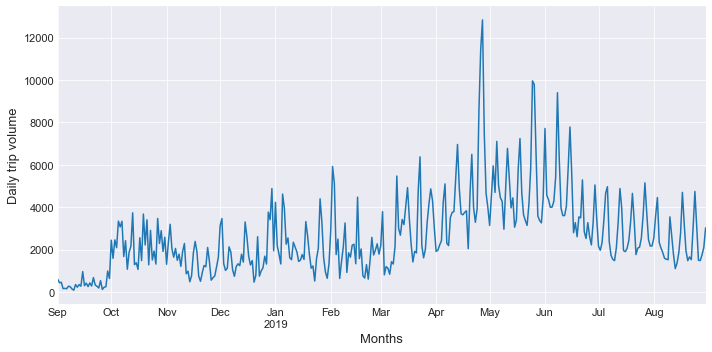

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

pd.DataFrame(
    data['startDateTime'].value_counts().resample('D').count()).plot.line(ax=ax)

#axis label
# _ = plt.title('Daily Trip count', fontsize=13)
_ = plt.xlabel('Months', fontsize=13)
_ = plt.ylabel('Daily trip volume', fontsize=13)
_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)

style.use('seaborn-darkgrid')
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('results/TemporalDistribution_AllData_DailyTrips_Year_V2_TimeZoneCorrected_08192021.png', dpi=900)

### Average hourly for week

In [11]:
#resample data by Hour and count number fo trips starting at that hour
weekday_avg_count = pd.DataFrame(
    data['startDateTime'].value_counts().resample('H').count()).rename(
        columns={'startDateTime': 'hourly_count'}).reset_index()

# #creating column for weekday no

weekday_avg_count['week_day'] = weekday_avg_count.apply(lambda x: x['index'].weekday(), axis=1)
weekday_avg_count['hour_no'] = weekday_avg_count.apply(lambda x: x['index'].hour, axis=1)

weekday_avg_count.head()

,index,hourly_count,week_day,hour_no
0,2018-09-01 07:00:00-05:00,7,5,7
1,2018-09-01 08:00:00-05:00,15,5,8
2,2018-09-01 09:00:00-05:00,56,5,9
3,2018-09-01 10:00:00-05:00,60,5,10
4,2018-09-01 11:00:00-05:00,117,5,11


#### Statistics for scooter trips for weekend

In [23]:
average_per_day=weekday_avg_count.groupby(['week_day'])['hourly_count'].mean()
typical_weekday=average_per_day[:3].mean()
typical_weekend=average_per_day[-2:].mean()
print(typical_weekday,typical_weekend)
print('ratio of typical weekend trip number by weekday',typical_weekend/typical_weekday)
print('proportion of trips higher in weekend than weekday',(typical_weekend-typical_weekday)/typical_weekday)

85.23103632478633 154.13055925742268
ratio of typical weekend trip number by weekday 1.8083853711467712
proportion of trips higher in weekend than weekday 0.8083853711467713


In [13]:
print(len(np.arange(0,24*7+7,12)))
print(len(['']+['12 pm','12 am']*7+['12 am']))

15
16


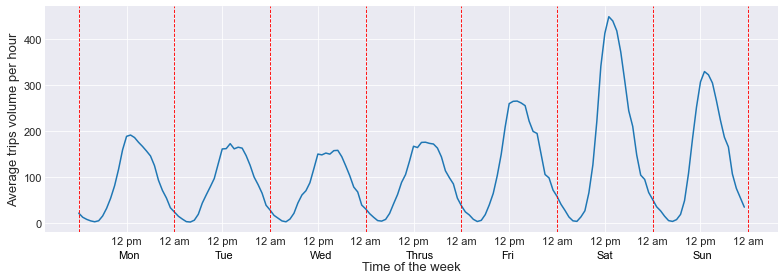

In [17]:
# weekday_avg_count.groupby(['week_day', 'hour_no'])['hourly_count'].mean().plot()

fig, ax = plt.subplots(figsize=(11, 4))

weekday_avg_count.groupby(['week_day',
                           'hour_no'])['hourly_count'].mean().plot(ax=ax)
for x in np.arange(0, 169, 24):
    ax.axvline(x=x, color='red', linewidth=0.9, linestyle='--')

day_label = ['Mon', 'Tue', 'Wed', 'Thrus', 'Fri', 'Sat', 'Sun']
for x in np.arange(1, 8, 1):
    ax.text(-14 + 24 * x, -75, day_label[x - 1], color='black', fontsize=11)

# axis tick label
# ax.set_yticklabels['12,24']

# # ax.xaxis.set_minor_locator(MultipleLocator(12))
# ax.xaxis.set_major_locator(MultipleLocator(12))
# ax.set_xticklabels(
#     [0, 0, 12, 24, 12, 24, 12, 24, 12, 24, 12, 24, 12, 24, 12, 24])
plt.xticks(np.arange(0,24*7+7,12),['']+['12 pm','12 am']*7)


#axis label
plt.xlabel('Time of the week', fontsize=13,labelpad=15)
plt.ylabel('Average trips volume per hour', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)

plt.tight_layout()
plt.savefig('results/TemporalDistribution_AllTrips_TimeOfWeek_V2_TimeZoneCorrected_08192021.png', dpi=300)

### 15 days with the highest trip count

In [41]:
data['startDateTime'].value_counts().resample('D').sum().sort_values(ascending=False)[:15].index

DatetimeIndex(['2019-04-27 00:00:00-05:00', '2019-04-26 00:00:00-05:00',
               '2019-05-25 00:00:00-05:00', '2019-05-26 00:00:00-05:00',
               '2019-06-01 00:00:00-05:00', '2019-06-08 00:00:00-05:00',
               '2019-05-18 00:00:00-05:00', '2019-04-25 00:00:00-05:00',
               '2019-05-17 00:00:00-05:00', '2019-06-15 00:00:00-05:00',
               '2019-04-28 00:00:00-05:00', '2019-05-05 00:00:00-05:00',
               '2019-04-13 00:00:00-05:00', '2019-04-21 00:00:00-05:00',
               '2019-05-03 00:00:00-05:00'],
              dtype='datetime64[ns, US/Central]', freq=None)

## Trip statistics

### Trip distance

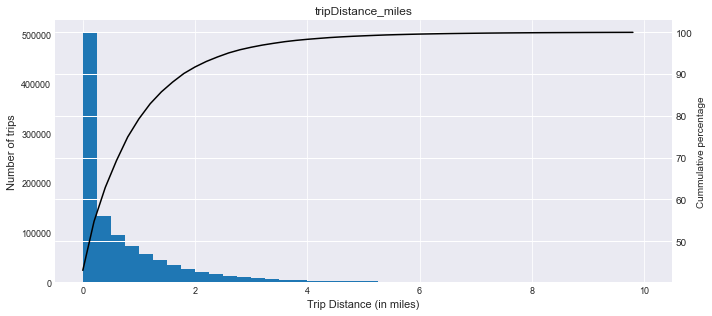

In [42]:
fig, ax = plt.subplots(figsize=(10, 4.5))

ax2 = ax.twinx()
data.hist('tripDistance_miles', ax=ax, bins=40)
data_distance = data[['tripDistance_miles']]

# evaluate the histogram
values, base = np.histogram(data_distance, bins=50)
# plt.suptitle('')

#evaluate the cumulative
cumulative = np.cumsum(values)

# plot the cumulative function
ax2.plot(base[:-1],
         cumulative / cumulative[-1] * 100,
         color='black',
         linewidth=1.5)
ax2.set_ylabel('Cummulative percentage')

ax.grid(color='w', linestyle='-', axis='y', linewidth=0)
ax2.grid(color='w', linestyle='-', linewidth=1)

# plt.title('Trip Distance', fontsize=13)

ax.set_xlabel('Trip Distance (in miles)', fontsize=11)
ax.set_ylabel('Number of trips', fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=9)
ax2.tick_params(axis='both', which='minor', labelsize=9)

#plt.title('Trip distance cummulative distribution')
plt.tight_layout()
# plt.savefig('plots/Trip_distance_plot.png', dpi=900)

### Trip duration

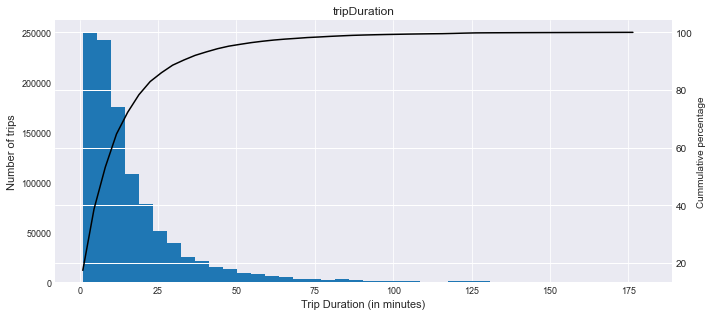

In [43]:
fig, ax = plt.subplots(figsize=(10, 4.5))

ax2 = ax.twinx()
data.hist('tripDuration', ax=ax, bins=40)
data_distance = data[['tripDuration']]

# evaluate the histogram
values, base = np.histogram(data_distance, bins=50)
# plt.suptitle('')

#evaluate the cumulative
cumulative = np.cumsum(values)

# plot the cumulative function
ax2.plot(base[:-1],
         cumulative / cumulative[-1] * 100,
         color='black',
         linewidth=1.5)
ax2.set_ylabel('Cummulative percentage')

ax.grid(color='w', linestyle='-', axis='y', linewidth=0)
ax2.grid(color='w', linestyle='-', linewidth=1)

# plt.title('Trip Distance', fontsize=13)

ax.set_xlabel('Trip Duration (in minutes)', fontsize=11)
ax.set_ylabel('Number of trips', fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=9)
ax2.tick_params(axis='both', which='minor', labelsize=9)

#plt.title('Trip distance cummulative distribution')
plt.tight_layout()
# plt.savefig('plots/Trip_duration_plot.png', dpi=900)

## Descriptive statistics of variables

In [18]:
model_data = pd.read_csv(
    '_Data/model data/model_data_TimeZoneCorrected_08192021.csv')  #.sample(2000, random_state=0)

## define variables for model
trip_variables = [
    'tripDistance_miles', 'tripDuration', 'route_directness_trace',
    'average_trip_speed_mph', 'high_trip_count_day', 'weekend_trip',
    'StartTime_AMPeak', 'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night',
    'PRCP', 'TAVG'
]

landuse_variables = [
    'MEAN_CBD_start',
    'MEAN_URBAN_start',
    'MEAN_SU_start',
    'MEAN_RURAL_start',
    'MEAN_POP_D_start',
    'MEAN_EMP_D_start',
    'MEAN_PAKING_start',
    'intersection_density_start',
    'enthropy_start',
    'MEAN_CBD_end',
    'MEAN_URBAN_end',
    'MEAN_SU_end',
    'MEAN_RURAL_end',
    'MEAN_POP_D_end',
    'MEAN_EMP_D_end',
    'MEAN_PAKING_end',
    'intersection_density_end',
    'enthropy_end',
]

flag_variables = [
    'PARK_start', 'VANDERBILT_start', 'NISSAN_start', 'PARK_end',
    'VANDERBILT_end', 'NISSAN_end'
]

remaining_var = [
    'trip_id', 'GRID_ID_start', 'GRID_ID_end', 'tripDistance',
    'euclidean_distance', 'StartTime_decimal', 'trip_start_hour_no', 'DATE_str'
]

variable_forPCA = trip_variables + landuse_variables

### rename variables

rename_variables = {
    'tripDistance_miles': 'Trip distance (miles)',
    'tripDuration': 'Trip duration (minutes)',
    'route_directness_trace': 'Route directness ratio',
    'average_trip_speed_mph': 'Average trip speed (mph)',
    'high_trip_count_day': 'Trips on special event',
    'weekend_trip': 'Weekend trips',
    'StartTime_AMPeak': 'Trip during 7 am and 10 am',
    'StartTime_Day': 'Trip during 10 am and 4 pm',
    'StartTime_PMPeak': 'Trip during 4 pm and 8 pm',
    'StartTime_Night': 'Trip during 8 pm and 7 am',
    'PRCP': 'Average daily precipitation',
    'TAVG': 'Average daily temperature',
    'MEAN_CBD_start': 'Proportion of CBD land use at origin',
    'MEAN_URBAN_start': 'Proportion of urban land use at origin',
    'MEAN_SU_start': 'Proportion of sub-urban land use at origin',
    'MEAN_RURAL_start': 'Proportion of rural land use at origin',
    'MEAN_POP_D_start': 'Average population density at origin',
    'MEAN_EMP_D_start': 'Average employment density at origin',
    'MEAN_PAKING_start': 'Average parking density at origin',
    'intersection_density_start':
    'Intersection density (per sq. miles) at origin',
    'enthropy_start': 'Entropy at origin',
    'MEAN_CBD_end': 'Proportion of CBD land use at destination',
    'MEAN_URBAN_end': 'Proportion of urban land use at destination',
    'MEAN_SU_end': 'Proportion of sub-urban land use at destination',
    'MEAN_RURAL_end': 'Proportion of rural land use at destination',
    'MEAN_POP_D_end': 'Average population density at destination',
    'MEAN_EMP_D_end': 'Average employment density at destination',
    'MEAN_PAKING_end': 'Average parking density at destination',
    'intersection_density_end':
    'Intersection density (per sq. miles) at destination',
    'enthropy_end': 'Entropy at destination'
}

### descriptive stat of variables

dummy_var = [
    'weekend_trip', 'high_trip_count_day', 'StartTime_AMPeak', 'StartTime_Day',
    'StartTime_PMPeak', 'StartTime_Night'
]
for var in dummy_var:
    print(model_data[var].value_counts())

descriptive_stat = round(
    model_data[variable_forPCA].describe().transpose().rename(
        index=rename_variables), 2)
descriptive_stat.to_csv('results/model_data_descriptive_stat_TimeZoneCorrected_08192021.csv')
descriptive_stat

## PCA variation explained

0    785477
1    265020
Name: weekend_trip, dtype: int64
0    907829
1    142668
Name: high_trip_count_day, dtype: int64
0    977684
1     72813
Name: StartTime_AMPeak, dtype: int64
0    541992
1    508505
Name: StartTime_Day, dtype: int64
0    751856
1    298641
Name: StartTime_PMPeak, dtype: int64
0    879959
1    170538
Name: StartTime_Night, dtype: int64


,count,mean,std,min,25%,50%,75%,max
Trip distance (miles),1050497.0,0.72,1.02,0.00,0.08,0.31,0.99,10.00
Trip duration (minutes),1050497.0,16.41,17.81,1.00,5.82,10.82,20.00,180.00
Route directness ratio,1050497.0,0.55,0.30,0.00,0.30,0.62,0.81,1.00
Average trip speed (mph),1050497.0,2.97,2.97,0.00,0.46,2.14,4.95,304.29
Trips on special event,1050497.0,0.14,0.34,0.00,0.00,0.00,0.00,1.00
Weekend trips,1050497.0,0.25,0.43,0.00,0.00,0.00,1.00,1.00
Trip during 7 am and 10 am,1050497.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
Trip during 10 am and 4 pm,1050497.0,0.48,0.50,0.00,0.00,0.00,1.00,1.00
Trip during 4 pm and 8 pm,1050497.0,0.28,0.45,0.00,0.00,0.00,1.00,1.00
Trip during 8 pm and 7 am,1050497.0,0.16,0.37,0.00,0.00,0.00,0.00,1.00


In [20]:
model_data['high_trip_count_day'].sum()/len(model_data)

0.1358100023131908

In [22]:
model_data['weekend_trip'].sum()

265020